In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("../data/winemag-data-130k-v2.csv", index_col = 0)

num = 51  # Row 50 is deleted if null prices are removed
df.head()

,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


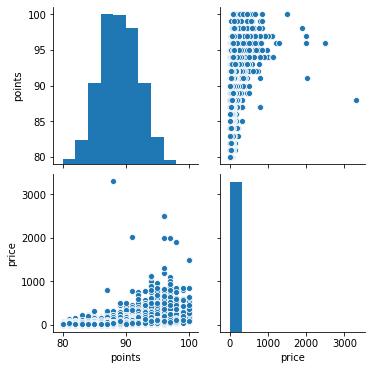

In [2]:
sns.pairplot(df)

In [3]:
df.isnull().sum()

country                     63
description                  0
designation              37465
points                       0
price                     8996
province                    63
region_1                 21247
region_2                 79460
taster_name              26244
taster_twitter_handle    31213
title                        0
variety                      1
winery                       0
dtype: int64

## Cleaning
Twitter user and name is rather pointless



In [4]:
# From Filip's notebook:
red = ['.*Noir.*','.*Cabernet Sauvignon.*','.*Red.*','.*Syrah.*','.*Merlot.*','.*Nebbiolo.*','.*Zinfandel.*','.*Sangiovese.*','.*Malbec.*','.*Tempranillo.*','.*Cabernet Franc.*','.*Gamay.*','.*Shiraz.*','.*Petite Sirah.*','.*Barbera.*','.*Port.*','.*Grenache.*','.*Corvina, Rondinella, Molinara.*','.*Carmenère.*','.*Nero d\'Avola.*','.*Aglianico.*','.*Garnacha.*']
white = ['.*Chardonnay.*','.*Riesling.*','.*Blanc.*','.*White.*','.*Gris.*','.*Grüner Veltliner.*','.*Grigio.*','.*Gewürztraminer.*','.*Viognier.*','.*Glera.*','.*Albariño.*','.*Moscato.*','.*Sauvignon.*','.*Verdejo.*']
sparkling = ['.*Sparkling.*','.*Champagne.*']
rose = ['.*Rosé.*','.*Rose.*']

def sort(dataframe):
    df_type = dataframe['variety']
    df_type = df_type.replace(to_replace=rose, value="Rose", regex=True)
    df_type = df_type.replace(to_replace=sparkling, value="Sparkling", regex=True)
    df_type = df_type.replace(to_replace=red, value="Red", regex=True)
    df_type = df_type.replace(to_replace=white, value="White", regex=True)
    df_type = df_type.replace(to_replace="^(?!Red)(?!White)(?!Sparkling)(?!Rose)", value=np.nan, regex=True)
    return df_type

sorted = sort(df)
sorted = sorted.rename("category")
df = df.join(sorted)
del sorted

In [5]:
tasters = df.taster_name.dropna().unique()
mapping = dict()
for i,t in enumerate(tasters):
    mapping[t] = int(i)

df = df.replace(mapping)

df.taster_name = df.taster_name.fillna(-1)
df['taster_name'] = df['taster_name'].round().astype(int)

In [6]:
df_clean = df.drop(["taster_twitter_handle", "region_2"], 1)

In [7]:
df_clean.isnull().sum()

country           63
description        0
designation    37465
points             0
price           8996
province          63
region_1       21247
taster_name        0
title              0
variety            1
winery             0
category       12356
dtype: int64

Since there's so few null values in country, we'll just remove those rows

In [8]:
df_clean = df_clean[df_clean['country'].notnull()]  
df_clean = df_clean[df_clean['variety'].notnull()]  # A single row
df_clean = df_clean[df_clean['price'].notnull()]
df_clean['price'] = df_clean['price'].round().astype(int)
df_clean.drop(df_clean[df_clean.price > 500].index, inplace=True)

In [9]:
#df_clean.isnull().sum()

In [10]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120824 entries, 1 to 129970
Data columns (total 12 columns):
country        120824 non-null object
description    120824 non-null object
designation    86101 non-null object
points         120824 non-null int64
price          120824 non-null int64
province       120824 non-null object
region_1       101325 non-null object
taster_name    120824 non-null int64
title          120824 non-null object
variety        120824 non-null object
winery         120824 non-null object
category       109445 non-null object
dtypes: int64(3), object(9)
memory usage: 12.0+ MB


### Removing duplicates from description


In [11]:
print("Unique descriptions: {}".format(len(df_clean['description'].unique())))

Unique descriptions: 111420


In [12]:
# Keep first occurrence of a duplicate row
df_clean = df_clean.drop_duplicates(subset=['description'], keep='first')

In [13]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 111420 entries, 1 to 129970
Data columns (total 12 columns):
country        111420 non-null object
description    111420 non-null object
designation    79425 non-null object
points         111420 non-null int64
price          111420 non-null int64
province       111420 non-null object
region_1       93481 non-null object
taster_name    111420 non-null int64
title          111420 non-null object
variety        111420 non-null object
winery         111420 non-null object
category       100986 non-null object
dtypes: int64(3), object(9)
memory usage: 11.1+ MB


In [14]:
#print("Are all descriptions unique: ", str(len(df_clean['description'].unique()) == len(df_clean['description'])))

### Sentiment Analysis
This did nothing - Removed from notebook

### The description duplicates seem to be mostly errors
In fact only one seem to be the same entry - Removed from notebook

## Tokenize words

In [15]:
import re
import nltk.tokenize

In [16]:
df_clean['description']= df_clean['description'].str.lower().apply(lambda e: re.sub('[^a-zA-Z]',' ', e))

In [17]:
import nltk
nltk.download('punkt')   # Not sure what this is exactly, but I need it to run word_tokenize
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /Users/mlj/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


**Takes ~30sec on my pc**

In [18]:
%%time
run_long = False
if run_long:
    desc_tokens_2 = df_clean['description'].apply(nltk.word_tokenize)
    print(desc_tokens_2[num])

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 6.91 µs


This is better:

In [19]:
%%time
desc_tokens_3 = df_clean['description'].apply(nltk.tokenize.RegexpTokenizer(r'\w+').tokenize)
print(desc_tokens_3[num])

['this', 'is', 'much', 'different', 'than', 'casa', 'silva', 's', 'petit', 'verdot', 'which', 'was', 'tasted', 'in', 'the', 'same', 'flight', 'the', 'is', 'more', 'hard', 'spicy', 'and', 'tarry', 'with', 'a', 'leafy', 'herbal', 'aroma', 'plus', 'some', 'grittiness', 'the', 'palate', 'feels', 'snappy', 'with', 'a', 'can', 't', 'miss', 'saltiness', 'the', 'finish', 'is', 'long', 'in', 'length', 'but', 'short', 'on', 'fruit', 'with', 'a', 'raw', 'feel']
CPU times: user 1.54 s, sys: 86.7 ms, total: 1.62 s
Wall time: 1.64 s


In [20]:
desc_tokens = desc_tokens_3.copy()

## Regexp is way better, now clean it


In [21]:
from collections import Counter

In [22]:
def analyze_words(word_lists):
    words = [word for sentence in word_lists for word in sentence]
    
    word_count = len(words)
    
    counts = Counter(words)
    common_words = counts.most_common(25)
    unique_words= len(counts)
    
    print("Total word count: {}\nUnique words {}!".format(word_count, unique_words))
    print("\nCommon words:")
    [print(i) for i in common_words]

analyze_words(desc_tokens)

Total word count: 4616551
Unique words 29459!

Common words:
('and', 302433)
('the', 190438)
('a', 154557)
('of', 149540)
('with', 103950)
('this', 97840)
('is', 81730)
('it', 74477)
('wine', 66541)
('flavors', 55548)
('in', 55076)
('to', 48365)
('s', 46836)
('fruit', 42570)
('on', 40166)
('that', 34296)
('aromas', 34231)
('palate', 33504)
('finish', 30931)
('acidity', 28871)
('from', 27694)
('but', 27509)
('tannins', 25814)
('drink', 25634)
('cherry', 25536)


## Word cleaning!

In [23]:
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /Users/mlj/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/mlj/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [24]:
stops = set(stopwords.words("english"))
filtered_words = desc_tokens.apply(lambda e : [w for w in e if w not in stops])

analyze_words(filtered_words)

Total word count: 2817392
Unique words 29314!

Common words:
('wine', 66541)
('flavors', 55548)
('fruit', 42570)
('aromas', 34231)
('palate', 33504)
('finish', 30931)
('acidity', 28871)
('tannins', 25814)
('drink', 25634)
('cherry', 25536)
('black', 24885)
('ripe', 22496)
('red', 18569)
('notes', 16602)
('spice', 16191)
('oak', 16014)
('dry', 15028)
('nose', 14939)
('rich', 14662)
('berry', 14509)
('fresh', 14483)
('full', 13613)
('plum', 13058)
('sweet', 11797)
('apple', 11627)


### Stemming

In [25]:
%%time
def stem_words(words):
    porter_stemmer = PorterStemmer()
    stemmed_words = words.apply(lambda e : [porter_stemmer.stem(w) for w in e])
    return stemmed_words
    #stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.82 µs


In [26]:
stemmed_words = stem_words(filtered_words)
analyze_words(stemmed_words)

Total word count: 2817392
Unique words 21052!

Common words:
('wine', 68950)
('flavor', 62599)
('fruit', 53732)
('finish', 35803)
('aroma', 35502)
('palat', 33615)
('acid', 33261)
('cherri', 29452)
('drink', 28847)
('tannin', 27647)
('black', 24912)
('ripe', 23995)
('dri', 22813)
('note', 21864)
('spice', 20014)
('red', 18787)
('rich', 18338)
('fresh', 18062)
('oak', 16549)
('berri', 16546)
('show', 15911)
('nose', 14953)
('plum', 14230)
('sweet', 13901)
('full', 13713)


### Lemmatization

In [27]:
lemmatizer = WordNetLemmatizer()

def lem_words(words):
    lemmatized_words = words.apply(lambda e : [lemmatizer.lemmatize(w) for w in e])
    return lemmatized_words

In [28]:
#lemmatized_words = lem_words(filtered_words)
#analyze_words(lemmatized_words)

### Both
Should maybe lem -> stem

In [29]:
lem_stem_words = stemmed_words.apply(lambda entry : [lemmatizer.lemmatize(w) for w in entry])  # This is ridiculous

In [30]:
analyze_words(lem_stem_words)

Total word count: 2817392
Unique words 21000!

Common words:
('wine', 68950)
('flavor', 62599)
('fruit', 53732)
('finish', 35803)
('aroma', 35502)
('palat', 33615)
('acid', 33261)
('cherri', 29452)
('drink', 28847)
('tannin', 27647)
('black', 24912)
('ripe', 23995)
('dri', 22813)
('note', 21864)
('spice', 20014)
('red', 18787)
('rich', 18338)
('fresh', 18062)
('oak', 16549)
('berri', 16546)
('show', 15911)
('nose', 14953)
('plum', 14230)
('sweet', 13901)
('full', 13713)


## Description length
### Original Dataset:


In [31]:
df_org = df.copy()

df_org['word_len'] = df_org['description'].apply(lambda x : len(x))
df_org['word_len'][num]

print("Description:\n{}\n\nLength:\n{}".format(df_org['description'][num], df_org['word_len'][num]))

Description:
This is much different than Casa Silva's 2009 Petit Verdot, which was tasted in the same flight. The '08 is more hard, spicy and tarry, with a leafy, herbal aroma, plus some grittiness. The palate feels snappy, with a can't-miss saltiness. The finish is long in length but short on fruit, with a raw feel.

Length:
305


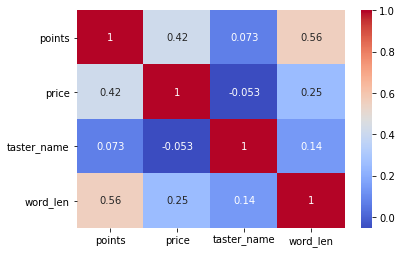

In [32]:
sns.heatmap(df_org.corr(),cmap='coolwarm',annot=True)

### Cleaned Dataset:

### Both lem and stem


In [33]:
df_lem_stm = df_clean.copy()

df_lem_stm['word_ind_len'] = lem_stem_words.apply(lambda sentence: sum(len(word) for word in sentence) / len(sentence))
df_lem_stm['clean_desc'] = lem_stem_words.apply(lambda sentence: ' '.join(sentence))
df_lem_stm['word_len'] = df_lem_stm['clean_desc'].apply(lambda x : len(x))

print("Description:\n{}\n\nLength:\n{}".format(df_lem_stm['clean_desc'][num], df_lem_stm['word_len'][num]))

print("Average word length: {}".format(df_lem_stm['word_ind_len'][num]))

Description:
much differ casa silva petit verdot tast flight hard spici tarri leafi herbal aroma plu gritti palat feel snappi miss salti finish long length short fruit raw feel

Length:
163
Average word length: 4.857142857142857


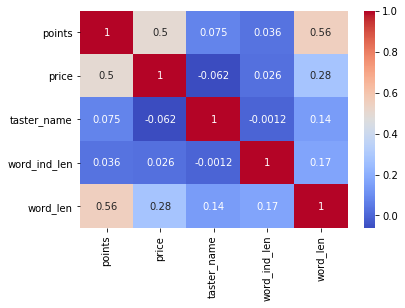

In [34]:
sns.heatmap(df_lem_stm.corr(),cmap='coolwarm',annot=True)

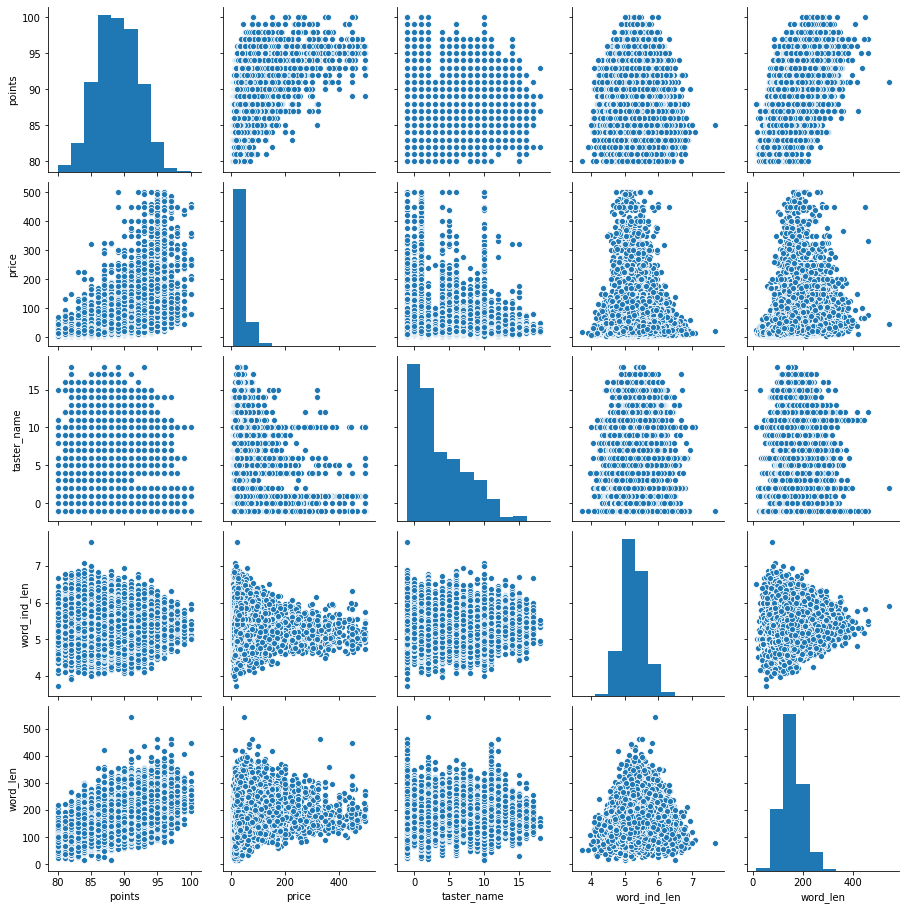

In [35]:
sns.pairplot(df_lem_stm)

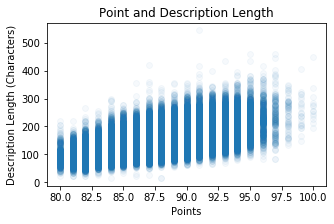

In [36]:
plt.figure(figsize=(5, 3))
plt.title("Point and Description Length")
plt.xlabel("Points")
plt.ylabel("Description Length (Characters)")
plt.scatter(df_lem_stm.points, df_lem_stm.word_len, alpha=0.04)

plt.show()

In [37]:
# Dropping individual word length from df
df_lem_stm = df_lem_stm.drop(['word_ind_len'], 1)
df_clean = df_lem_stm.copy()
print(list(df_clean))

['country', 'description', 'designation', 'points', 'price', 'province', 'region_1', 'taster_name', 'title', 'variety', 'winery', 'category', 'clean_desc', 'word_len']


##  vectorizer

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split

#########################################################################
# When running model:
# 1000 Features will take ~5gb ram (PEAK)
# 3000 Features will take ~5gb ram (PEAK)
# 5000 Features will take ~23gb ram (PEAK) and will likely kill the kernel
# 21000 will take in excess of 27gb
#########################################################################

#tf_vector = TfidfVectorizer(smooth_idf=False, sublinear_tf=False, norm=None, analyzer='word')
def vectorize_words(words, features=1000, need_vect=False):
    tf_vector = TfidfVectorizer(analyzer='word', max_features=features, token_pattern=r'\w+',)
    vectorized_words = tf_vector.fit_transform(words)
    
    if not need_vect:
        return vectorized_words
    else:
        return vectorized_words, tf_vector
    
vectorized_words, tf_vector = vectorize_words(df_clean['clean_desc'], need_vect=True)
idf = tf_vector.idf_
tf_vector.get_feature_names()[:25]

['abund',
 'accent',
 'access',
 'accompani',
 'acid',
 'acr',
 'across',
 'ad',
 'add',
 'addit',
 'aftertast',
 'age',
 'aggress',
 'air',
 'alcohol',
 'allow',
 'allur',
 'almond',
 'almost',
 'along',
 'alongsid',
 'alreadi',
 'also',
 'although',
 'alway']

In [39]:
# Will print all selected features and idf score
#print(dict(zip(tf_vector.get_feature_names(), idf)))

In [40]:
idf_sort = np.argsort(tf_vector.idf_)
idf_features = np.array(tf_vector.get_feature_names())

print("Lowest idf(Least important): {}".format(idf_features[idf_sort[:10]]))
print("Highest idf(Highest weighted): {}".format(idf_features[idf_sort[-10:]]))

Lowest idf(Least important): ['flavor' 'wine' 'fruit' 'finish' 'aroma' 'palat' 'acid' 'drink' 'cherri'
 'tannin']
Highest idf(Highest weighted): ['nacion' 'elderberri' 'gew' 'bare' 'infus' 'coast' 'own' 'scorch'
 'carignan' 'third']


In [41]:
vectorized_words.shape

(111420, 1000)

In [42]:
def split_data(df, y):
    X = df.copy()
        
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    return X_train, X_val, X_test, y_train, y_val, y_test

**Logistic regression performed horribly and has been omitted**

# Run the model

In [43]:
from catboost import cv, CatBoostRegressor, Pool

In [44]:
a_f = 1500            # Amount of features
c_d = False           # Include catagorical data
y_label = 'points'    # Train on price or points
iterations = 5000     # Amount of iterations
t_depth = 8           # Tree depth
loss_f = 'RMSE'       # Loss function
catagorical_features = ['taster_name','price', 'winery', 'province', 'country', 'word_len'] #This does nothing atm. TODO function to take these and drop rest + get indices
cat_indices = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9] # Indeces to use as categorical data

In [45]:
def get_data(df_p, vect_words, with_cat=False):
    df_vectorized_words = pd.DataFrame(vect_words.toarray())  # .todense() vs .toarray()?
    print(y_label)
    y = pd.DataFrame(df_p[y_label])
    df_gd_tmp = None
    cat_data = []
    if with_cat:
        cat_data = cat_indices
        df_gd_tmp = df_p.copy()
        df_gd_tmp = df_gd_tmp.drop([y_label,'description','clean_desc', 'region_1'], 1)
        print("Catagorical data chosen: " + str(list(df_gd_tmp)[:len(cat_data)]))
        # Title, designation seems to do nothing
        
        df_gd_tmp = df_gd_tmp.fillna(-1)
        df_gd_tmp = pd.concat([df_gd_tmp.reset_index(drop=True), df_vectorized_words.reset_index(drop=True)], axis=1)
    else:
        df_gd_tmp  = df_vectorized_words
    
    print(df_gd_tmp.info())
    X_train, X_val, X_test, y_train, y_val, y_test = split_data(df_gd_tmp, y)
    return X_train, X_val, X_test, y_train, y_val, y_test, cat_data

In [46]:
def get_vect_data(amount_features, catagorical_data=False):
    vect_words, tf_vector = vectorize_words(df_clean['clean_desc'], amount_features, need_vect=True)
    X_train, X_val, X_test, y_train, y_val, y_test, cat_data = get_data(df_clean, vect_words, with_cat=catagorical_data)
    return X_train, X_val, X_test, y_train, y_val, y_test, cat_data, vect_words, tf_vector

X_train, X_val, X_test, y_train, y_val, y_test, cat_data, vect_words, tf_vector = get_vect_data(a_f, True)
#X_train_wo, X_val_wo, X_test_wo, y_train_wo, y_val_wo, y_test_wo, cat_data_wo, vect_words_wo, tf_vector_wo = get_vect_data(a_f)

points
Catagorical data chosen: ['country', 'designation', 'price', 'province', 'taster_name', 'title', 'variety', 'winery', 'category', 'word_len']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111420 entries, 0 to 111419
Columns: 1510 entries, country to 1499
dtypes: float64(1500), int64(3), object(7)
memory usage: 1.3+ GB
None


In [47]:
# NOTE! Cannot do catagorical data. This is just for TF-IDF data
def get_best_params(X, y, model): 
    params = {'depth': [4, 6, 10],
               'l2_leaf_reg': [1, 3, 5, 7, 9],
               'learning_rate': [0.01, 0.005]
               }
    res = model.grid_search(params,
                    X,
                    y=y,
                    cv=3, 
                    plot=True)
    return res

In [48]:
%%time
def train_model(X_train, y_train, X_val, y_val,
                cat_data,
                iterations=2000,
                t_depth=8,
                loss_f='RMSE',
                verbose=False,
                load_model_e=None,
                save_model_e=None):

    cbr = CatBoostRegressor(max_ctr_complexity=1,
                             boosting_type='Plain',
                             max_bin=128,
                             random_seed=13, 
                             loss_function=loss_f,
                             iterations=iterations,
                             learning_rate=0.01,
                             task_type='CPU', # Collab does not have GPU, if on own pc and nvidia GPU  use that 'GPU'
                             logging_level=None,
                             depth=t_depth,
                             bagging_temperature=0.3,
                             metric_period=50,
                             verbose=True)

    if verbose:
        print(cbr.get_params())

    if load_model_e:
        loaded_cbr = CatBoostRegressor(logging_level=None)
        loaded_cbr.load_model(load_model_e)
        if verbose:
            print(loaded_cbr.get_params())
        cbr = loaded_cbr
    else:
        cbr.fit(X_train,
                y_train[y_label],
                eval_set=(X_val, y_val[y_label]),
                cat_features=cat_data,
                #plot=True,
                verbose=False)  # Verbose prints all iterations with their learning rate

        if save_model_e:
            cbr.save_model(save_model_e)
            if verbose:
                print("Model has been saved")
    return cbr

## FIND BEST PARAMETERS
#best_params = get_best_params(X_train, y_train['points'], cbr)
#print(best_params)

cbr = train_model(X_train, y_train, X_val, y_val, cat_data, iterations, 8)
#cbr_wo_cat = train_model(X_train_wo, y_train_wo, X_val_wo, y_val_wo, cat_data_wo, iterations, 8)

CPU times: user 1h 44min 53s, sys: 2min 58s, total: 1h 47min 51s
Wall time: 30min 6s


**This takes a long time running on here without GPU**<br>
At least with 5k iterations and 1500 word features and tree depth of 8

In [49]:
y_pred_w = cbr.predict(X_test)
#y_pred_wo = cbr_wo_cat.predict(X_test_wo)

In [50]:
def get_rmse(predictions, labels):
    return np.sqrt(((predictions - labels) ** 2).mean())

def score_model(cbr, y_pred, X_train, y_train, X_test, y_test, cat_data):
    prds = []
    for i in range(len(y_pred)):
        prediction =  float("%.2f" % y_pred[i])
        label = y_test[y_label].iloc[i]
        # I know percentage difference is wrong
        # I mean, the score is 80-100
        # Normalize then do percentage? Find a better solution, or figure out why RMSE is weird
        difference = float("%.2f" % ((abs(prediction - label)/((prediction + label)/2))*100))
        actual_difference = float("%.2f" % (abs(prediction - label)))
        prds.append([prediction, label, actual_difference, difference]) #rounded])

    np_prds = np.array(prds)

    print(f"With catagorical features: {True if cat_data else False}")
    print(f"Iterations: {iterations}")
    print(f"Amount of features: {a_f}")
    print(f"Depth: {t_depth}")
    print(f"Loss function: {loss_f}")
    print("Learning score: {learn}\nValidation score: {validation}".format(loss_f, **cbr.best_score_))
    print("RMSE test score: {}".format(get_rmse(y_pred, y_test[y_label])))
    print("Train score: {}".format(cbr.score(X_train, y_train[y_label]))) 
    print("Test score: {}".format(cbr.score(X_test, y_test[y_label])))

    print("Difference:")
    print("Average: {:.4}%".format(np_prds[:,3].mean()))
    print("Maximum: {:.4}%".format(np_prds[:,3].max()))

    print("Average point difference: {:.4}".format(np_prds[:,2].mean()))

    #false_count = sum(np_prds[:,3])
    #print("False counts: {}, Total: {}".format(false_count, len(np_prds)))

    max_row = np.argmax(np_prds[:,0], axis=0)
    min_row = np.argmin(np_prds[:,0], axis=0)

    avg_pred = np_prds[:,0].mean()
    avg_test = np_prds[:,1].mean()

    print("Maximum prediction: {}".format(prds[max_row]))
    print("Minimum prediction: {}".format(prds[min_row]))

    print("Average prediction: {}".format(avg_pred))
    print("Average test :      {}".format(avg_test))

    print("Prediction | Actual label | Difference | Difference %|")
    [print(n, sep="\n") for n in prds[2100:2125]]

score_model(cbr, y_pred_w, X_train, y_train, X_test, y_test, cat_data)
#score_model(cbr_wo_cat, y_pred_wo, X_train_wo, y_train_wo, X_test_wo, y_test_wo)

With catagorical features: True
Iterations: 5000
Amount of features: 1500
Depth: 8
Loss function: RMSE
Learning score: {'RMSE': 1.3878538057442615}
Validation score: {'RMSE': 1.4417278885095295}
RMSE test score: 1.4414109322208395
Train score: 0.8186187106503905
Test score: 0.7840056782498357
Difference:
Average: 1.271%
Maximum: 8.52%
Average point difference: 1.123
Maximum prediction: [96.66, 96, 0.66, 0.69]
Minimum prediction: [80.2, 80, 0.2, 0.25]
Average prediction: 88.42791958355771
Average test :      88.40728774008257
Prediction | Actual label | Difference | Difference %|
[89.72, 90, 0.28, 0.31]
[86.29, 88, 1.71, 1.96]
[90.64, 92, 1.36, 1.49]
[89.52, 91, 1.48, 1.64]
[92.7, 93, 0.3, 0.32]
[90.58, 90, 0.58, 0.64]
[85.15, 85, 0.15, 0.18]
[94.24, 95, 0.76, 0.8]
[88.24, 87, 1.24, 1.42]
[92.63, 93, 0.37, 0.4]
[85.64, 83, 2.64, 3.13]
[86.25, 87, 0.75, 0.87]
[89.38, 90, 0.62, 0.69]
[85.1, 84, 1.1, 1.3]
[85.18, 87, 1.82, 2.11]
[91.65, 92, 0.35, 0.38]
[85.39, 85, 0.39, 0.46]
[87.47, 88, 0

In [51]:
cbr.best_iteration_

4999

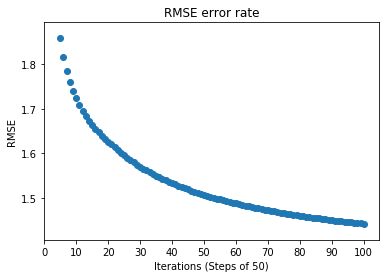

In [52]:
start = 5
plt.scatter(range(start, len( cbr.evals_result_['validation']['RMSE'])), cbr.evals_result_['validation']['RMSE'][start:])
plt.title("RMSE error rate")
plt.xlabel("Iterations (Steps of 50)")
plt.ylabel("RMSE")
plt.xticks(range(0, 101, 10))
plt.show()

In [53]:
from scipy.stats import linregress
slope = linregress(y_pred_w, y_test.points).slope
intercept = linregress(y_pred_w,y_test.points).intercept
print(slope)

1.0266143410331476


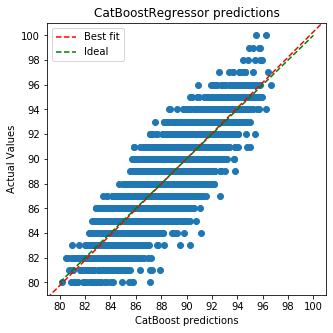

In [54]:
def plot_predictions(slope, intercept):
    plt.figure(figsize=(5, 5))
    plt.title("CatBoostRegressor predictions")
    plt.xlabel("CatBoost predictions")
    plt.ylabel("Actual Values")
    plt.scatter(y_pred_w, y_test, color='tab:blue')
    axes = plt.gca()
    axes.set_xlim([79,101])
    axes.set_ylim([79,101])
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, linestyle='--', color='red', label="Best fit")
    x1, y1 = [80, 100], [80, 100]
    plt.plot(x1, y1, linestyle='--', color='green', label="Ideal")
    plt.legend(loc="upper left")
    plt.xticks(range(80, 101, 2))
    plt.yticks(range(80, 101, 2))
    plt.show()
    
plot_predictions(slope, intercept)


In [55]:
train_data = None
if cat_data:
    train_data = Pool(X_train, label=y_train, cat_features=cat_data)
else:
    train_data = Pool(X_train, label=y_train)
    

feature_importance = cbr.get_feature_importance(type="PredictionValuesChange", #LossFunctionChange
                               data=train_data,
                               prettified=True)
feature_importance


,Feature Id,Importances
0,word_len,26.690875
1,price,14.214105
2,taster_name,10.388967
3,winery,6.369152
4,province,3.030406
...,...,...
1505,1488,0.000000
1506,1489,0.000000
1507,1491,0.000000
1508,1496,0.000000


In [56]:
# this could be a couple of lines...
def get_words(num_words):
    return get_important_words(num_words)

def get_ints(feature):
    try:
        i = int(feature)
        a = str(tf_vector.get_feature_names()[i])
        return f"\"{a}:{i}\""
    except ValueError:
        return feature

def get_feature_names(features):
    new_features = []
    for f in features:
        new_features.append(get_ints(f))
        
    return new_features

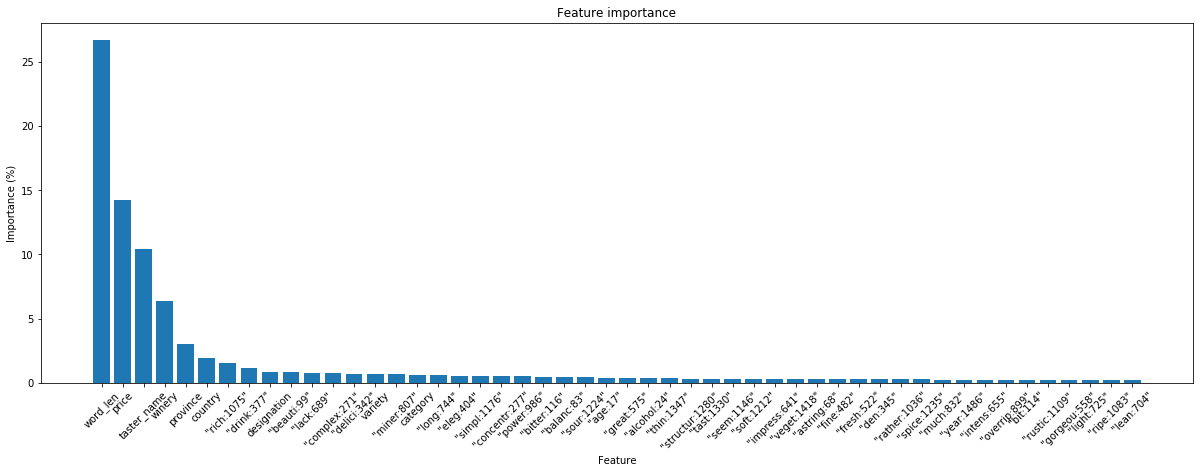

In [57]:
def plot_importance(feature_importance):
    fig = plt.figure(figsize=(16,5))
    ax = fig.add_axes([0,0,1,1])
    features = feature_importance['Feature Id'][:50]
    x = get_feature_names(features)
    y = feature_importance['Importances'][:50]
    ax.bar(x, y)
    plt.xticks(rotation=45)
    plt.title("Feature importance")
    plt.xlabel("Feature")
    plt.ylabel("Importance (%)")
    plt.show()
ids = plot_importance(feature_importance)

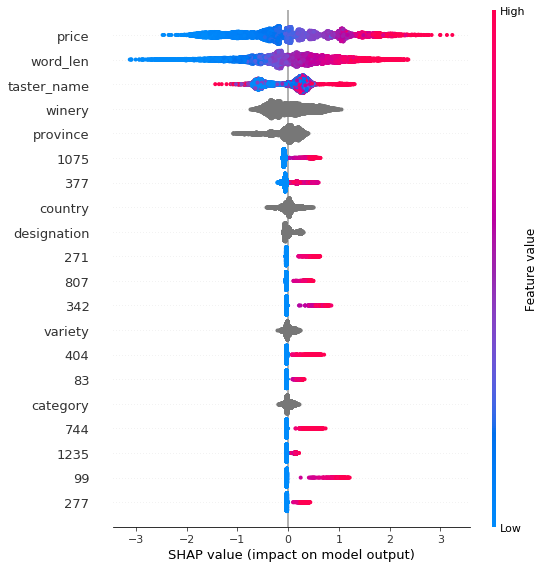

In [59]:
#!pip install shap
import shap

def get_shap():
    shap.initjs()
    train_data = Pool(X_test, label=y_test, cat_features=cat_data)
    shap_values = cbr.get_feature_importance(type="ShapValues",
                                             data=train_data)
    
    shap_values = shap_values[:,:-1]
    
    shap.summary_plot(shap_values, X_test)

get_shap()

Not entirely sure how to read this, reds are what help give a higher prediction and blues are for lower prediction
So from seeing this, we should remove taster_name from the model?

In [60]:
if not cat_data: # This is useless pt
    train_pool = Pool(X_test, label=y_test, cat_features=cat_data)
    train_pool_slice = train_pool.slice([2, 3])

    prediction_diff = cbr.get_feature_importance(train_pool_slice,
                                                   type='PredictionDiff',
                                                   prettified=True)

    cbr.plot_predictions(data=train_pool_slice,
                           features_to_change=prediction_diff["Feature Id"][:5],
                           plot=True)

In [61]:
#Random forest has been omitted from this notebook